#### 주제 : 장마철 태양광 발전 공백 분석: ESS 최소 필요 용량 산정

목적 : 장마철 강수량이 태양광 발전량에 미치는 영향을 분석하고
       전력 공백을 메우기 위한 ESS(에너지저장장치) 필요 용량 계산

데이터:
 - 장마철(6~7월), 비장마철(4~5월)
 - 강수량: 2020~2025년 서울 4~7월 월별 데이터
 - 일사량: 2020~2025년 서울 4~7월 월별 데이터

분석 질문
 - 장마철 태양광 발전량이 평시 대비 얼마나 감소하나?
 - 연속으로 발전량이 낮은 기간(공백기)은 며칠인가?
 - 이 기간을 버티려면 ESS 용량이 얼마나 필요한가?
 - 지역별로 필요 용량이 다른 이유는(지역별은 일단 보류/현재는 서울만)

In [33]:
# 기본 설정 및 함수 정의
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'   # Windows
plt.rcParams['axes.unicode_minus'] = False      # 마이너스 기호 깨짐 방지
plt.rcParams['figure.dpi'] = 100                # 그래프 해상도
sns.set_style("whitegrid")

# 전역 상수
PANEL_AREA = 20
MONTHLY_NEED = 4000
EFFICIENCY = 0.18
LOSS = 0.8
ESS_UNIT_PRICE = 500000

1. 강수량 데이터 로드

In [42]:
import pandas as pd

# 함수 정의
def load_weather_csv(file_path):
    start_row = None
    with open(file_path, encoding='cp949') as f:
        for i, line in enumerate(f):
            if '지점번호' in line:
                start_row = i
                break
    
    df = pd.read_csv(file_path, encoding='cp949', skiprows=start_row, engine='python')
    df.columns = df.columns.str.strip().str.replace('"', '')
    df['일시'] = pd.to_datetime(df['일시'].astype(str).str.strip(), errors='coerce')
    df = df.dropna(subset=['일시']).sort_values('일시').reset_index(drop=True)
    
    return df

# 파일 로드
weather_67 = load_weather_csv('seoul_weather_6~7.csv')
weather_45 = load_weather_csv('seoul_weather_4~5.csv')

print("\n장마철 강수량:")
print(weather_67.head())

print("\n비장마철 강수량:")
print(weather_45.head())


장마철 강수량:
   지점번호 지점명         일시  강수량(mm)  일최다강수량(mm)    일최다강수량일자  1시간최다강수량(mm)  \
0   108  서울 2020-06-01    139.6        64.7  2020-06-30          15.9   
1   108  서울 2020-07-01    270.4       103.1  2020-07-23          27.1   
2   108  서울 2021-06-01    104.6        38.2  2021-06-27          37.7   
3   108  서울 2021-07-01    168.3        67.4  2021-07-19          65.7   
4   108  서울 2022-06-01    393.8       176.2  2022-06-30          34.4   

   1시간최다강수량일자  Unnamed: 8  
0  2020-06-30         NaN  
1  2020-07-29         NaN  
2  2021-06-27         NaN  
3  2021-07-19         NaN  
4  2022-06-23         NaN  

비장마철 강수량:
   지점번호 지점명         일시  강수량(mm)  일최다강수량(mm)    일최다강수량일자  1시간최다강수량(mm)  \
0   108  서울 2020-04-01     16.9        10.3  2020-04-19           3.9   
1   108  서울 2020-05-01    112.4        29.8  2020-05-18          19.8   
2   108  서울 2021-04-01    124.1        56.2  2021-04-03          11.5   
3   108  서울 2021-05-01    183.1        66.9  2021-05-16          11.3   
4   108

2. 일사량 데이터 로드

In [41]:
def load_solar_csv(file_path):
    df = pd.read_csv(file_path, encoding='cp949', skiprows=17, engine='python')
    df.columns = df.columns.str.strip()
    df['일시'] = pd.to_datetime(df['일시'])
    return df.sort_values('일시').reset_index(drop=True)

solar_67 = load_solar_csv('seoul_solar_data_6~7.csv')
solar_45 = load_solar_csv('seoul_solar_data_4~5.csv') 

print("\n장마철 일사량:")
print(solar_67.head())  

print("\n비장마철 일사량:")
print(solar_45.head())  


장마철 일사량:
   지점번호 지점명         일시  일조합(hr)  일조율(%)  일사합(MJ/m2)
0   108  서울 2015-06-01    258.1   58.39      530.22
1   108  서울 2015-07-01    176.1   39.23      428.46
2   108  서울 2016-06-01    229.7   51.97      508.07
3   108  서울 2016-07-01    160.4   35.76      403.01
4   108  서울 2017-06-01    285.2   64.51      625.27

비장마철 일사량:
   지점번호 지점명         일시  일조합(hr)  일조율(%)  일사합(MJ/m2)
0   108  서울 2020-04-01    283.3   71.59      637.52
1   108  서울 2020-05-01    177.9   40.38      564.83
2   108  서울 2021-04-01    208.6   52.74      558.28
3   108  서울 2021-05-01    203.7   46.25      570.50
4   108  서울 2022-04-01    246.4   62.35      615.24


3. 발전량 계산

In [40]:
# MJ/m² → kWh/m² 변환
# 일사량 변환: MJ/m² × 0.2778 = kWh/m²
solar_67['일사량(kWh/m²)'] = solar_67['일사합(MJ/m2)'] * 0.2778
solar_45['일사량(kWh/m²)'] = solar_45['일사합(MJ/m2)'] * 0.2778

# 발전량 계산 (패널 20m², 효율 18%, 손실 20%)
solar_67['발전량(kWh)'] = solar_67['일사량(kWh/m²)'] * 20 * 0.18 * 0.8
solar_45['발전량(kWh)'] = solar_45['일사량(kWh/m²)'] * 20 * 0.18 * 0.8

# 전체 컬럼 확인
print("장마철:")
print(solar_67)

print("\n비장마철:")
print(solar_45)

장마철:
    지점번호 지점명         일시  일조합(hr)  일조율(%)  일사합(MJ/m2)  일사량(kWh/m²)    발전량(kWh)
0    108  서울 2015-06-01    258.1   58.39      530.22   147.295116  424.209934
1    108  서울 2015-07-01    176.1   39.23      428.46   119.026188  342.795421
2    108  서울 2016-06-01    229.7   51.97      508.07   141.141846  406.488516
3    108  서울 2016-07-01    160.4   35.76      403.01   111.956178  322.433793
4    108  서울 2017-06-01    285.2   64.51      625.27   173.700006  500.256017
5    108  서울 2017-07-01    123.1   27.44      375.27   104.250006  300.240017
6    108  서울 2018-06-01    236.6   53.51      602.59   167.399502  482.110566
7    108  서울 2018-07-01    228.5   52.64      561.10   155.873580  448.915910
8    108  서울 2019-06-01    235.1   53.18      589.02   163.629756  471.253697
9    108  서울 2019-07-01    150.1   33.44      426.99   118.617822  341.619327
10   108  서울 2020-06-01    206.1   46.62      603.98   167.785644  483.222655
11   108  서울 2020-07-01    119.4   26.62      464.55   129.

4. 데이터 병합

In [11]:
# 장마철
merged_67 = pd.merge(
    weather_67[['일시', '강수량(mm)']],
    solar_67[['일시', '일사량(kWh/m²)', '발전량(kWh)', '일조합(hr)']],
    on='일시'
)

# 비장마철
merged_45 = pd.merge(
    weather_45[['일시', '강수량(mm)']],
    solar_45[['일시', '일사량(kWh/m²)', '발전량(kWh)', '일조합(hr)']],
    on='일시' # 같은 날짜끼리 붙이기
)

# 발전량 비교

print("="*30)
print("발전량 분석")
print("="*30)

avg_power_67 = merged_67['발전량(kWh)'].mean()
avg_power_45 = merged_45['발전량(kWh)'].mean()
power_loss = avg_power_45 - avg_power_67
loss_percent = (power_loss / avg_power_45) * 100

print(f"\n비장마철 평균 발전량: {avg_power_45:.0f} kWh")
print(f"장마철 평균 발전량: {avg_power_67:.0f} kWh")
print(f"→ 장마철 감소: {power_loss:.0f} kWh ({loss_percent:.1f}% 감소)")


발전량 분석

비장마철 평균 발전량: 484 kWh
장마철 평균 발전량: 429 kWh
→ 장마철 감소: 55 kWh (11.4% 감소)


5. 상관관계 분석

In [12]:
# corr 파이썬 코드

# 상관계수 (강수량과 발전량을 -1~1 사이 숫자로 표현)
# -1에 가까우면: 강수량 많을수록 발전량 적음 (강한 음의 관계)
# 0에 가까우면: 관계 없음
# +1에 가까우면: 강수량 많을수록 발전량 많음 (강한 양의 관계)

# 추세선 계산 (y = ax + b 형태의 직선 방정식 만들기)
# z_67[0] = 기울기(a) → 비 1mm 증가 시 전기 변화량
# z_67[1] = 절편(b) → 비가 0mm일 때 기본 전기량

# z_67 = np.polyfit(
#     merged_67['강수량(mm)'],  # x축: 비 온 양
#     merged_67['발전량(kWh)'],   # y축: 만든 전기
#     1                           # 1차 방정식 (직선)
# )

# abs(): 절댓값 (음수를 양수로)
# z_67[0]*100: 기울기 × 100 (비 100mm 증가 효과) -> mm는 크기가 작아서 체감 안되므로
# :.0f: 소수점 없이 정수로 표시

In [13]:
print("\n" + "="*30)
print("상관관계 분석")
print("="*30 + "\n")

# 장마철 상관관계
corr_67 = merged_67[['강수량(mm)', '발전량(kWh)']].corr().iloc[0, 1]
z_67 = np.polyfit(merged_67['강수량(mm)'], merged_67['발전량(kWh)'], 1)

# 비장마철 상관관계
corr_45 = merged_45[['강수량(mm)', '발전량(kWh)']].corr().iloc[0, 1]
z_45 = np.polyfit(merged_45['강수량(mm)'], merged_45['발전량(kWh)'], 1)

print(f"장마철 상관계수: {corr_67:.3f}")
print(f"  → 강수량 100mm ↑ → 발전량 {abs(z_67[0]*100):.0f}kWh ↓")
print(f"\n비장마철 상관계수: {corr_45:.3f}")
print(f"  → 강수량 100mm ↑ → 발전량 {abs(z_45[0]*100):.0f}kWh ↓")


상관관계 분석

장마철 상관계수: -0.825
  → 강수량 100mm ↑ → 발전량 37kWh ↓

비장마철 상관계수: -0.340
  → 강수량 100mm ↑ → 발전량 33kWh ↓


6. ESS 용량 계산

In [14]:
print("\n" + "="*30)
print("ESS 필요 용량 (일반 가정 기준)")
print("="*30 + "\n")

PANEL_AREA = 20  # m²
MONTHLY_NEED = 400 # 4인 가족 평균 한 달 동안 필요한 전기량 = 400kWh
worst = merged_67.loc[merged_67['발전량(kWh)'].idxmin()] # 장마철 중에서 발전량이 가장 적었던 달
shortage = max(0, MONTHLY_NEED - worst['발전량(kWh)']) # 필요한 전기 - 만든 전기 = 부족한 전기
                                                       # max(0,...) -> max(0, -100) = 0 음수 대신 0출력, 부족하지 않으면 0으로
recommended = shortage * 1.2    # 부족량에 20% 여유분 추가
commercial = int(np.ceil(recommended / 10)) * 10 # 상용 제품 단위로 올림 (실제 제품: 10kWh, 20kWh, 30kWh...단위로 판매)

print(f"\n패널 면적: {PANEL_AREA}m² (약 15개)")
print(f"월 필요량: {MONTHLY_NEED} kWh (4인 가족)")
print(f"평균 발전량: {merged_67['발전량(kWh)'].mean():.0f} kWh")
print(f"최악 발전량: {worst['발전량(kWh)']:.0f} kWh ({worst['일시'].strftime('%Y년 %m월')})")
print(f"부족량: {shortage:.0f} kWh")
print(f"권장 ESS: {commercial} kWh")
print(f"예상 비용: 약 {commercial * 500000:,}원") # 용량 * 단가 = 총 비용
                                                 # 50만원은 ESS 배터리 시장 평균 단가


ESS 필요 용량 (일반 가정 기준)


패널 면적: 20m² (약 15개)
월 필요량: 400 kWh (4인 가족)
평균 발전량: 429 kWh
최악 발전량: 322 kWh (2024년 07월)
부족량: 78 kWh
권장 ESS: 100 kWh
예상 비용: 약 50,000,000원


In [15]:
import numpy as np
# ===============================
# 기본 설정
# ===============================
PANEL_AREA = 20        # m²
MONTHLY_NEED = 400     # kWh (4인 가구 평균)
ESS_UNIT = 10          # 상용 ESS 단위 (kWh)
ESS_PRICE = 500_000    # kWh 당 가격 (원)
# ===============================
# ESS 계산 함수 (공통)
# ===============================
def calc_ess(df, label):
    worst = df.loc[df['발전량(kWh)'].idxmin()]
    shortage = max(0, MONTHLY_NEED - worst['발전량(kWh)'])
    recommended = shortage * 1.2
    commercial = int(np.ceil(recommended / ESS_UNIT) * ESS_UNIT)
    return {
        "구분": label,
        "평균발전량": df['발전량(kWh)'].mean(),
        "최저발전량": worst['발전량(kWh)'],
        "최저월": worst['일시'],
        "부족량": shortage,
        "ESS용량": commercial,
        "비용": commercial * ESS_PRICE
    }
result_rainy = calc_ess(merged_67, "장마철")
result_non_rainy = calc_ess(merged_45, "비장마철")
print("\n" + "=" * 45)
print("장마철 / 비장마철 ESS 필요 용량 비교")
print("=" * 45)
for r in [result_rainy, result_non_rainy]:
    print(f"\n[{r['구분']}]")
    print(f"평균 발전량: {r['평균발전량']:.0f} kWh")
    print(
        f"최저 발전량: {r['최저발전량']:.0f} kWh "
        f"({r['최저월'].strftime('%Y년 %m월')})"
    )
    print(f"부족 전력량: {r['부족량']:.0f} kWh")
    print(f"권장 ESS 용량: {r['ESS용량']} kWh")
    print(f"예상 ESS 비용: 약 {r['비용']:,} 원")


장마철 / 비장마철 ESS 필요 용량 비교

[장마철]
평균 발전량: 429 kWh
최저 발전량: 322 kWh (2024년 07월)
부족 전력량: 78 kWh
권장 ESS 용량: 100 kWh
예상 ESS 비용: 약 50,000,000 원

[비장마철]
평균 발전량: 484 kWh
최저 발전량: 398 kWh (2023년 04월)
부족 전력량: 2 kWh
권장 ESS 용량: 10 kWh
예상 ESS 비용: 약 5,000,000 원


7. 시각화 (그래프)

In [16]:
import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic')  # 맑은 고딕
plt.rc('axes', unicode_minus=False)     # 마이너스 기호

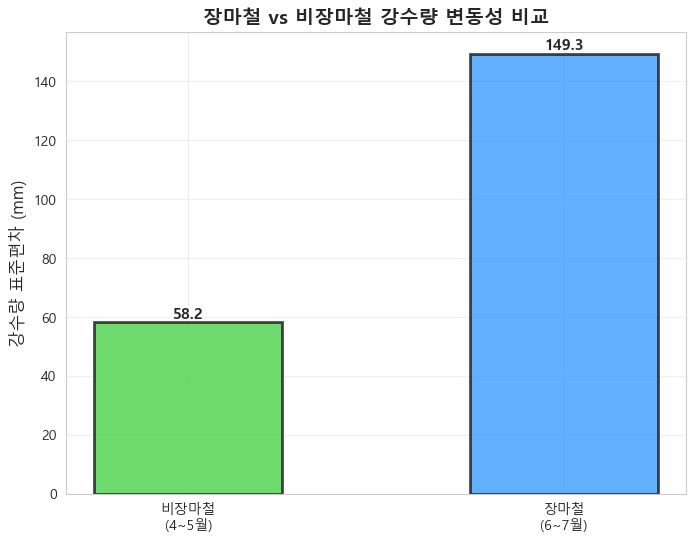

In [17]:
# 장마철 vs 비장마철 강수량 변동성 비교

plt.figure(figsize=(8, 6))

# 표준편차 계산
# 표준편차 = 데이터가 평균에서 얼마나 흩어져 있는지 나타내는 값
# 숫자가 클수록 변동성이 큼 (비가 왔다 안 왔다 차이가 심함)
std_45 = weather_45['강수량(mm)'].std()
std_67 = weather_67['강수량(mm)'].std()

# 막대그래프
categories = ['비장마철\n(4~5월)', '장마철\n(6~7월)']
values = [std_45, std_67]
colors = ['limegreen', 'dodgerblue']

bars = plt.bar(categories, values,
               color=colors, 
               alpha=0.7,
               edgecolor='black', 
               linewidth=2,
               width=0.5)

# 막대 위에 값 표시
plt.bar_label(bars, fmt='%.1f', fontsize=11, fontweight='bold')

# 그래프 꾸미기
plt.title('장마철 vs 비장마철 강수량 변동성 비교', fontsize=14, fontweight='bold')
plt.ylabel('강수량 표준편차 (mm)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

년도별 평균 일사량 변화

In [46]:
# solar_67['연도'] = solar_67['일시'].dt.year
# solar_45['연도'] = solar_45['일시'].dt.year
# yearly_67 = solar_67.groupby('연도')[['일사합(MJ/m2)', '일조합(hr)']].mean()
# yearly_45 = solar_45.groupby('연도')[['일사합(MJ/m2)', '일조합(hr)']].mean()
# plt.figure(figsize=(8,4))
# plt.plot(yearly_45.index, yearly_45['일사합(MJ/m2)'], marker='o', label='비장마철-일사량')
# plt.plot(yearly_67.index, yearly_67['일사합(MJ/m2)'], marker='o', label='장마철-일사량')
# plt.title("년도별 평균 일사량 변화")
# plt.xlabel("연도"); plt.ylabel("MJ/m²")
# plt.legend()
# plt.grid(alpha=0.3)
# plt.show()
# plt.figure(figsize=(8,4))
# plt.plot(yearly_45.index, yearly_45['일조합(hr)'], marker='o', label='비장마철-일조합')
# plt.plot(yearly_67.index, yearly_67['일조합(hr)'], marker='o', label='장마철-일조합')
# plt.title("년도별 평균 일조시간 변화")
# plt.xlabel("연도")
# plt.ylabel("hr")
# plt.legend()
# plt.grid(alpha=0.3)
# plt.show()

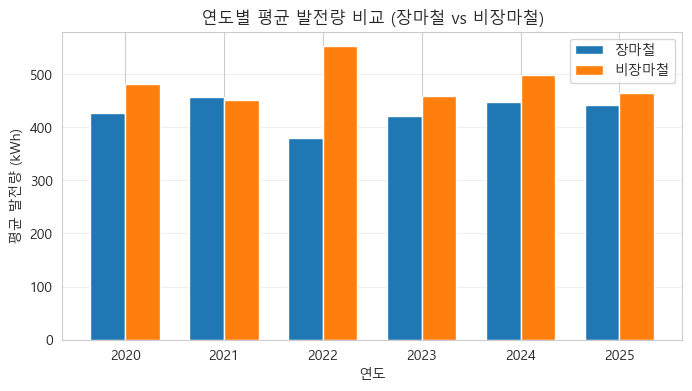

In [18]:
# 연도 컬럼 (이미 있으면 생략)
solar_67['연도'] = solar_67['일시'].dt.year
solar_45['연도'] = solar_45['일시'].dt.year
# 연도별 평균 발전량
yearly_rain = solar_67.groupby('연도')['발전량(kWh)'].mean()
yearly_dry  = solar_45.groupby('연도')['발전량(kWh)'].mean()
years = sorted(set(yearly_rain.index) & set(yearly_dry.index))
x = np.arange(len(years))
width = 0.35
plt.figure(figsize=(8,4))
plt.bar(x - width/2, yearly_rain.loc[years], width, label='장마철')
plt.bar(x + width/2, yearly_dry.loc[years],  width, label='비장마철')
plt.xticks(x, years)
plt.title('연도별 평균 발전량 비교 (장마철 vs 비장마철)')
plt.xlabel('연도')
plt.ylabel('평균 발전량 (kWh)')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

장마철(6~7월) 월별 발전량 추이

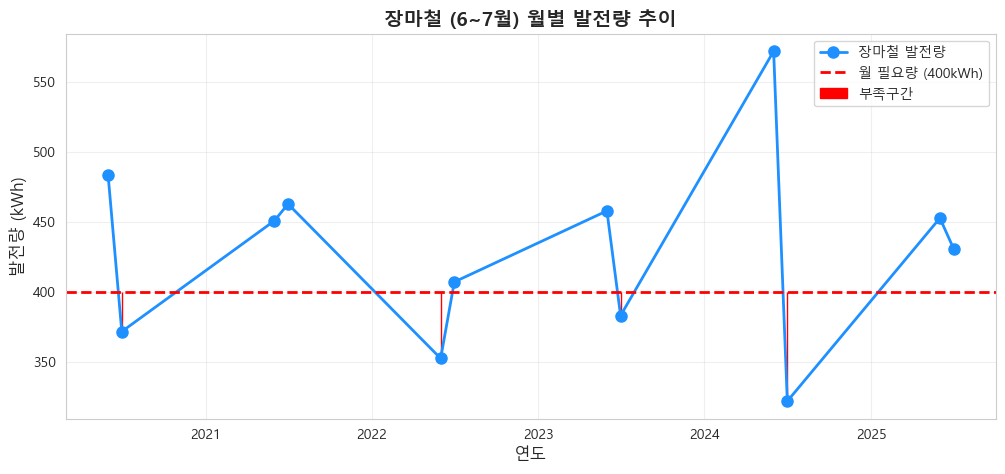

In [19]:
plt.figure(figsize=(12, 5))

# 선 그래프 그리기
# - x축: 날짜 (merged_67['일시'])
# - y축: 발전량 (merged_67['발전량(kWh)'])
# - marker='o': 점 표시 (동그라미)
# - linewidth=2: 선 굵기
# - markersize=8: 점 크기

plt.plot(merged_67['일시'], merged_67['발전량(kWh)'],
         marker='o', linewidth=2, markersize=8,
         color='dodgerblue', label='장마철 발전량')

# 수평선 그리기 (월 필요량 400kWh를 빨간 점선으로)
# axhline(): 축을 따라 수평선을 표시
# -y=400: y축 400 위치에 선 그리기
# -linestyle='--': 점선

plt.axhline(y=400, color='red', linestyle='--', linewidth=2, label='월 필요량 (400kWh)' )

# 부족한 구간 색칠하기
# fill_between(): 두 수평 방향의 곡선 사이 채우기
# - 400과 실제 발전량 사이를 빨간색으로 채우기
# - where 조건: 발전량이 400보다 작을 때만 색칠

plt.fill_between(merged_67['일시'], 400, merged_67['발전량(kWh)'],
                 where=(merged_67['발전량(kWh)'] < 400),
                 color='red', label = '부족구간')

# 그래프 꾸미기

plt.title('장마철 (6~7월) 월별 발전량 추이', fontsize=14, fontweight='bold')
plt.xlabel('연도', fontsize=12)
plt.ylabel('발전량 (kWh)', fontsize=12)
plt.legend(loc='upper right') # 범례 (우측 상단)
plt.grid(True, alpha=0.3) # 격자 (투명도 30%)

plt.show()

비장마철 연도별 발전량 추이

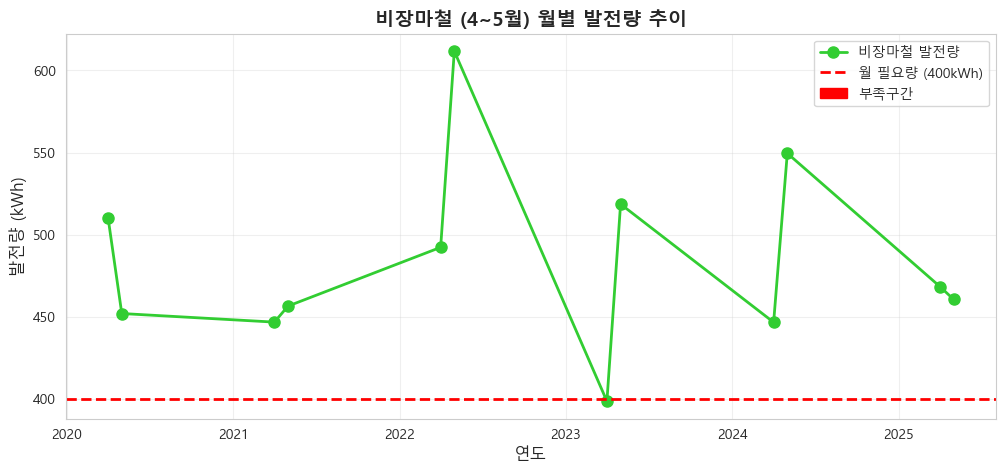

In [20]:
plt.figure(figsize=(12, 5))

plt.plot(merged_45['일시'], merged_45['발전량(kWh)'],
        marker='o',
        linewidth=2, markersize=8,
        color='limegreen', label='비장마철 발전량')

plt.axhline(y=400, color='red', linestyle='--', linewidth=2, label='월 필요량 (400kWh)')

plt.fill_between(merged_45['일시'], 400, merged_45['발전량(kWh)'],
                 where=(merged_45['발전량(kWh)'] < 400),
                 color='red', label = '부족구간')

plt.title('비장마철 (4~5월) 월별 발전량 추이', fontsize=14, fontweight='bold')
plt.xlabel('연도', fontsize=12)
plt.ylabel('발전량 (kWh)', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.show()

ESS 필요량 분석 (장마철 vs 비장마철)

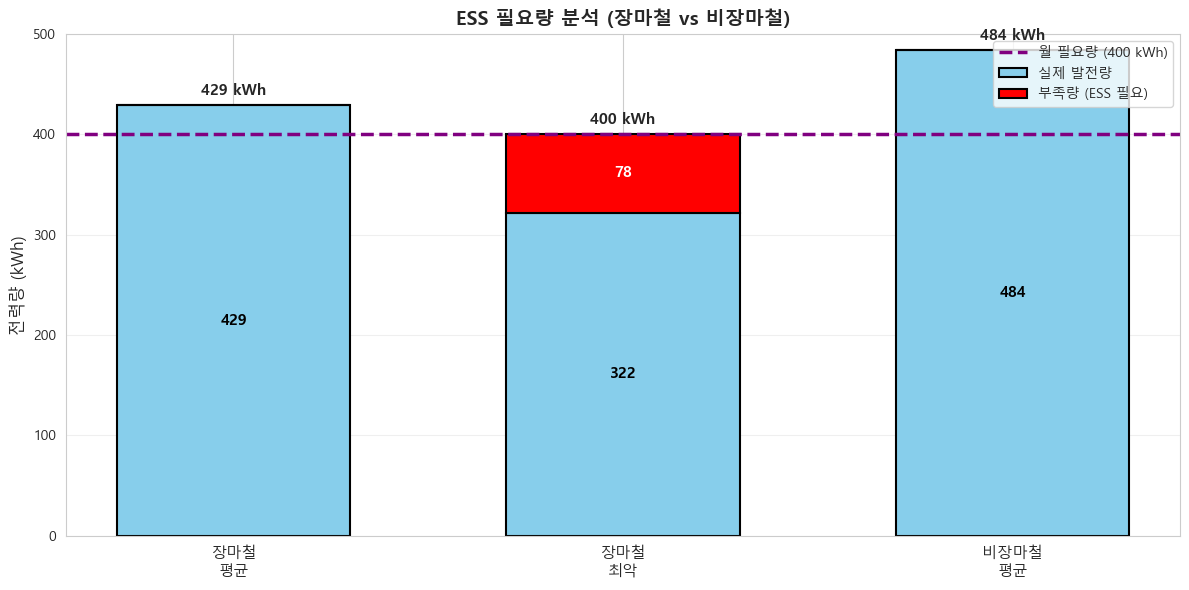

In [32]:
# ESS 필요량 분석 (장마철 vs 비장마철)

# 큰 그림(fig)과 그 안에 그래프 공간(ax)
fig, ax = plt.subplots(figsize=(12, 6))

# ===== 데이터 준비 =====

# x축 라벨 (막대 3개)
categories = ['장마철\n평균', '장마철\n최악', '비장마철\n평균']

# 실제 발전량
power_values = [
    merged_67['발전량(kWh)'].mean(),
    worst['발전량(kWh)'],
    merged_45['발전량(kWh)'].mean()
]

# 부족량 계산
# 부족량 = 필요량(400) - 발전량
# 만약 발전량이 필요량보다 많으면 0 (부족 없음)
shortage_values = [
    max(0, MONTHLY_NEED - merged_67['발전량(kWh)'].mean()),
    max(0, MONTHLY_NEED - worst['발전량(kWh)']),
    max(0, MONTHLY_NEED - merged_45['발전량(kWh)'].mean())
]

# ===== 그래프 그리기 =====

# x축 위치 (0, 1, 2)
x = np.arange(len(categories)) # len(categories) = 3이므로 np.arange(3) = [0, 1, 2]
                               # 첫 번째 막대는 x=0 위치, 두 번째 막대는 x=1 위치, 세 번째 막대는 x=2 위치
width = 0.6 # 막대 너비

# 파란색 막대: 실제 발전량
bars1 = ax.bar(x, power_values, width,
               label='실제 발전량',
               color='skyblue',
               edgecolor='black',
               linewidth=1.5)

# 빨간색 막대: 부족량 (파란색 막대 위에 쌓기)
bars2 = ax.bar(x, shortage_values, width,
               bottom=power_values,
               label='부족량 (ESS 필요)',
               color='red',
               edgecolor='black',
               linewidth=1.5)

# ===== 기준선 그리기 =====

# 보라색 점선: 월 필요량 400kWh
ax.axhline(y=MONTHLY_NEED,
           color='purple',
           linestyle='--',
           linewidth=2.5,
           label=f'월 필요량 ({MONTHLY_NEED} kWh)')

# ===== 막대 위에 숫자 표시 =====

for i in range(len(categories)):
    power = power_values[i]       # 발전량
    short = shortage_values[i]    # 부족량
    total = power + short         # 합계

# 막대 위에 합계 표시
    ax.text(i,                        # x좌표: 막대 중앙 (0, 1, 2)
        total + 10,               # y좌표: 막대 끝에서 10 위쪽
        f'{total:.0f} kWh',       # 표시할 텍스트: 소수점 없이 정수로
        ha = 'center',            # 수평 중앙 정렬 (막대 중앙에 맞춤)
        fontsize=11,
        fontweight='bold')

# 파란색 막대 가운데에 발전량 표시
    ax.text(i,
        power/2,
        f'{power:.0f}',
        ha='center',
        va='center',
        fontsize=11,
        color='black',
        fontweight='bold')

# 빨간색 막대 가운데에 부족량 표시 (부족량이 있을 때만)
    if short > 0:
        ax.text(i,
            power + short/2,
            f'{short:.0f}',
            ha='center',
            va='center',
            fontsize=11,
            color='white',
            fontweight='bold')
    

# ===== 그래프 꾸미기 ======

ax.set_ylabel('전력량 (kWh)', fontsize=12)
ax.set_title('ESS 필요량 분석 (장마철 vs 비장마철)', fontsize=14, fontweight='bold')
ax.set_xticks(x)                             # x축 위치
ax.set_xticklabels(categories, fontsize=11)  # x축 라벨
ax.legend(loc='upper right', fontsize=10)    # 범례 (우측 상단)
ax.set_ylim(0, 500)                          # y축 범위 (0~500)
ax.grid(True, alpha=0.3, axis='y')           # y축만 격자 표시

plt.tight_layout()
plt.show()